# Hate speech detection task

Hate speech detection is the automated task of determining whether a piece of text contains hateful content. In this project, I built a classifier using PyTorch and a pre-trained BERT model.

**Data source:** Hate Towards the Political Opponent: A Twitter Corpus Study of the 2020 US Elections on the Basis of Offensive Speech and Stance Detection https://www.ims.uni-stuttgart.de/forschung/ressourcen/korpora/stance-hof/

## GPU set-up

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Load libraries

In [4]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.7 MB/s eta 0:00:00


In [5]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
from string import punctuation
from collections import Counter
import random
import operator
from tqdm import tqdm
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertModel, BertTokenizer

## Load data

Note that I will only use two of the columns: 'text' and 'HOF' (i.e. the label). The other columns (sentiment towards Trump, Biden and West) are superfluous to the current (simple) task.

In [6]:
def load_data(path, sample_size=5, cols=['text', 'HOF'], label=None):
    """Helper function that loads data from a given path into a pandas
       DataFrame, using only the specified cols. Also prints basic info
       about the dataset size and displays a sample of the rows.
    """

    df = pd.read_csv(path, sep='\t', usecols=cols)

    print(f"\nThere are {df.shape[0]} tweets in the {label} dataset.")
    print("\nHere's a sample:\n")
    display(df.sample(sample_size))

    return df

In [8]:
# Colab
train = load_data('train.tsv', label='train')
test = load_data('test.tsv', label='test')


There are 2400 tweets in the train dataset.

Here's a sample:



,text,HOF
456,@realDonaldTrump We are waiting for you Mr pre...,Non-Hateful
1185,Kushner Says Trump Policies Work For Black Peo...,Non-Hateful
1867,@KamalaHarris @JoeBiden Joe seriously could po...,Hateful
622,Newly surfaced video of Joe Biden speaking to ...,Non-Hateful
613,Oof... I LOVE our president. Nobody has EVER h...,Non-Hateful



There are 600 tweets in the test dataset.

Here's a sample:



,text,HOF
95,#OperationFlagDrop[NEWLINE]#Trump2020 [NEWLINE...,Non-Hateful
43,"Twitter is a service, not a right. KayLie spre...",Non-Hateful
250,See how the reporter covers for him? What the ...,Non-Hateful
249,Great to welcome new followers to my page incl...,Non-Hateful
58,If you are okay with being dependent on a syst...,Non-Hateful


In [9]:
# Local
# train = load_data(path=Path.cwd()/'data/GrimmingerKlingerWASSA2021/train.tsv', label='train')
# test = load_data(path=Path.cwd()/'data/GrimmingerKlingerWASSA2021/test.tsv', label='test')

In [10]:
# Are there any duplicates?
assert len(train['text'].drop_duplicates()) == len(train['text'])
assert len(test['text'].drop_duplicates()) == len(test['text'])

## Quick inspection / visualisation

In [12]:
!pip install matplotlib --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


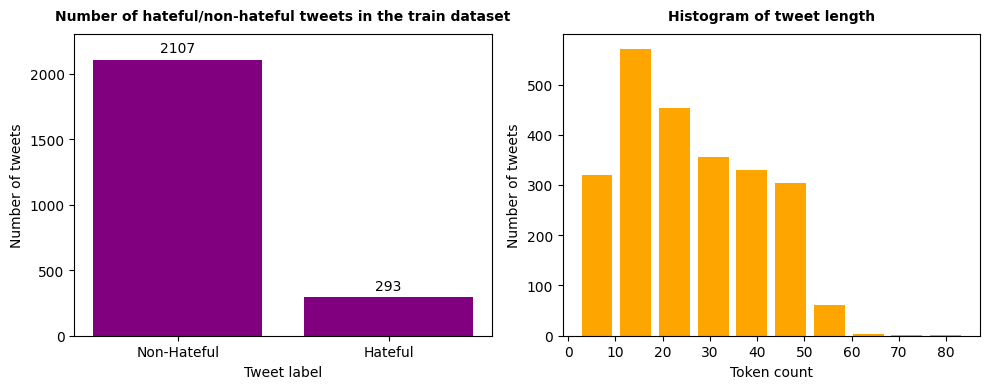

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Distribution by class
ax[0].bar(x = train['HOF'].unique(), # Data labels
       height = train['HOF'].value_counts().values, # Num of tweets in each category
       color='purple')

ax[0].bar_label(ax[0].containers[0], label_type='edge', padding=3) # Annotate bars
ax[0].set_ylim(0, 2300) # Raise upper limit of y-axis, to accommodate labels

ax[0].set_title("Number of hateful/non-hateful tweets in the train dataset",
             fontweight='bold', fontsize=10, y = 1.02)
ax[0].set_ylabel("Number of tweets")
ax[0].set_xlabel('Tweet label')

# Distribution by length
ax[1].hist([len(tweet) for tweet in train['text'].apply(lambda x: x.split())],
           color='orange', rwidth=0.8)
ax[1].set_xlabel('Token count')
ax[1].set_ylabel('Number of tweets')
ax[1].set_title("Histogram of tweet length",
                fontweight='bold', fontsize=10, y = 1.02)


plt.tight_layout()
plt.show()

## Preprocess data
At this stage, I will just map the labels to integers. Later, I will conduct more preprocessing.

In [14]:
# Map labels to binary integers
label2id = {'Non-Hateful': 0, 'Hateful': 1}
train['HOF'] = train['HOF'].apply(lambda x: label2id[x])
test['HOF'] = test['HOF'].apply(lambda x: label2id[x])

## Deal with class imbalances
For simplicity / for now, I'll just downsample from the majority ('Non-Hateful') class.

In [15]:
print('Before downsampling: ')
print(f"Hateful: {len(train[train['HOF']==1])}")
print(f"Non-Hateful: {len(train[train['HOF']==0])}")

train_hateful = train[train['HOF']==1]
train_nonhateful = train[train['HOF']==0].sample(len(train_hateful))
train_downsampled = pd.concat([train_hateful, train_nonhateful], axis=0).sample(frac=1)

print('\nAfter downsampling: ')
print(f"Hateful: {len(train_downsampled[train_downsampled['HOF']==1])}")
print(f"Non-Hateful: {len(train_downsampled[train_downsampled['HOF']==0])}")

Before downsampling: 
Hateful: 293
Non-Hateful: 2107

After downsampling: 
Hateful: 293
Non-Hateful: 293


## Split train data set into train and development sets
To provide a way to assess the model's performance after each training loop.

In [16]:
# Split train data set into train and development sets
train, dev = train_test_split(train_downsampled, test_size=0.5, stratify=train_downsampled['HOF'])

## Prepare data

Before we can build and train our model, we need to convert the text and labels into a format that is acceptable for the model. To do this, we need two tools:
* `torch.utils.data.Dataset` - stores the samples and their corresponding labels. I also use it to create a simple pipeline for cleaning and tokenizing the tweets. I will use the `bert-base-uncased` tokenizer so that the tokenizer matches the model. This is because (1) the model has a specific, fixed vocabulary, and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.
* `torch.utils.data.DataLoader` - wraps an iterable around the `Dataset`, enabling us to iterate through the samples. Can also be used to transform the data (if you provide a custom `collate_fn`).


In [17]:
# Clean the tweets' text
def clean_text(tweet):
    """A function that performs basic cleaning of a tweet's text.
    """

    # Replace mentions and URLs with special token
    tweet = re.sub(r"@[A-Za-z0-9_-]+",'USR',tweet)
    tweet = re.sub(r"http\S+",'URL',tweet)

    # Remove \n and \t characters
    tweet = tweet.replace('\n', ' ')
    tweet = tweet.replace('[NEWLINE]', ' ')
    tweet = tweet.replace('\t', ' ')

    # Strip whitespace
    tweet = tweet.strip()

    # Convert to lowercase
    tweet = tweet.lower()

    # return [w.strip(punctuation) for w in tweet.split() if w.strip(punctuation)!='']
    return tweet

# train['cleaned_text'] = train['text'].apply(lambda x: clean_text(x))
# test['cleaned_text'] = test['text'].apply(lambda x: clean_text(x))

In [18]:
# Define Dataset class which cleans, tokenizes and encodes data
class BERTDataset(Dataset):

    def __init__(self, data):

        # Initialize BERT tokenizer
        # Note that I need to specify cache_dir because I'm using a venv
        self.tok = BertTokenizer.from_pretrained('bert-base-uncased', cache_dir=Path.cwd()/'venv/lib/python3.8/site-packages')

        # Clean tweets
        self.cleaned_tweets = data['text'].apply(lambda x: clean_text(x))

        # Truncate and encode tweets, up to max_length of 60
        # While this is lower than BERT's max (512), it was chosen for computational speed
        self.tweets = list(self.cleaned_tweets.apply(self.tok.encode, max_length=60, truncation=True))

        # Store labels
        self.labels = list(data['HOF'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tweet = self.tweets[idx]
        label = self.labels[idx]
        return tweet, label

# Inspect an example
# BD = BERTDataset(train.iloc[:5])
# next(iter(BD))

In [19]:
# Define collate function to be passed to DataLoader
def bert_collate(batch):

    # Store batch size
    batch_size = len(batch)

    # Separate tweets and labels
    tweets = [t for t, _ in batch]
    labels = torch.tensor([l for _, l in batch]).long()

    # Store length of longest tweet in batch
    max_len = max(len(t) for t in tweets)

    # Create padded tweet and attention mask tensors
    tweets_pad = torch.zeros((batch_size, max_len)).long()
    masks_pad = torch.zeros((batch_size, max_len)).long()
    for i, t in enumerate(tweets):
        tweets_pad[i, :len(t)] = torch.tensor(t)
        masks_pad[i, :len(t)] = 1

    return tweets_pad, masks_pad, labels

In [20]:
%%time

# Create data sets
train_dataset = BERTDataset(train)
dev_dataset = BERTDataset(dev)
test_dataset = BERTDataset(test)

CPU times: user 1.98 s, sys: 18.2 ms, total: 2 s
Wall time: 5.75 s


In [21]:
# Create data loaders using torch.utils.data.DataLoader class
# Using shuffle=True instead of specifying RandomSampler
train_loader = DataLoader(train_dataset, batch_size=100, collate_fn=bert_collate, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=100, collate_fn=bert_collate)
test_loader = DataLoader(test_dataset, batch_size=100, collate_fn=bert_collate)

In [22]:
# Inspect
for (idx, batch) in enumerate(train_loader):

    print(f'\n\n--------------------- Batch {idx} ---------------------\n')

    # Print the text
    print(f"There are {len(batch[0])} encoded tweets in this batch.")
    print('Tweets (encoded): ', batch[0])

    # Print the label
    print(f"There are {len(batch[2])} encoded labels in this batch. Here they are: ")
    print('Labels: ', batch[2])



--------------------- Batch 0 ---------------------

There are 100 encoded tweets in this batch.
Tweets (encoded):  tensor([[ 101, 8398, 1024,  ..., 1005, 1056,  102],
        [ 101, 2149, 2099,  ...,    0,    0,    0],
        [ 101, 2149, 2099,  ...,    0,    0,    0],
        ...,
        [ 101, 2149, 2099,  ...,    0,    0,    0],
        [ 101, 2149, 2099,  ...,    0,    0,    0],
        [ 101, 1045, 8415,  ...,    0,    0,    0]])
There are 100 encoded labels in this batch. Here they are: 
Labels:  tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 1])


--------------------- Batch 1 ---------------------

There are 100 encoded tweets in this batch.
Tweets (encoded):  tensor([[  101,  2149,  2099

In [23]:
# Define BERT classifier
class BERTClassifier(nn.Module):

    def __init__(self):

        # Specify network layers
        # Note that I need to specify cache as I'm using a venv
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', cache_dir=Path.cwd()/'venv/lib/python3.8/site-packages')
        self.linear = nn.Linear(768, 4)

        # Define dropout
        self.dropout = nn.Dropout(0.2)

        # Freeze BERT layers
        for n, p in self.bert.named_parameters():
            p.requires_grad = False

    def forward(self, tweets, masks):

        # Define flow of tensors through the network
        output_bert = self.bert(tweets, attention_mask=masks)[0].mean(axis=1)
        return self.linear(self.dropout(output_bert))

In [24]:
# Initialise model
model = BERTClassifier()

The warning above: This only means that the pretrained head of the BERT model is discarded, and replaced with a randomly initialised classification head. It doesn't matter that this is randomly initialised because we will now fine-tune this new model head via training below.

In [25]:
# Move model to device
model = model.to(device)

In [26]:
# Define optimiser, objective function and epochs
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
epochs = 5

In [27]:
%%time

# Train model
for epoch_i in range(1, epochs):

    # ========================================
    #               Training
    # ========================================

    # Put model into training mode. This is necessary so that the `Dropout`
    # layers are activated.
    model.train()

    # For each batch of the training data...
    for i, batch in enumerate(tqdm(train_loader)):

        # Step 1. Since PyTorch accumulates gradients, clear any previously
        # calculated gradients before performing a backward pass.
        # PyTorch doesn't do this automatically because it can be useful while
        # training RNNs.
        optimizer.zero_grad()

        # Step 2. Extract data and move to device.
        tweets, masks, labels = [t.to(device) for t in batch]

        # Step 3. Forward pass - note that calling `model()` will in turn call
        # the model's `forward()` function.
        output = model(tweets, masks)

        # Step 4. Compute loss.
        loss = criterion(output, labels)

        # Step 5. Perform backward pass to calculate gradients wrt each w and b term.
        loss.backward()

        # Step 6. Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Step 7. Update parameters and take a step using the computed gradient.
        optimizer.step()

    # ========================================
    #               Validation
    # ========================================

    # After the completion of each training epoch, measure our performance on
    # our validation set.
    # Put model into evaluation mode, thereby deactivating Dropout layer.
    model.eval()

    y_true = list()
    y_pred = list()

    with torch.no_grad(): # We no longer need it to store computation graph.
        for batch in dev_loader:
            tweets, masks, labels = [t.to(device) for t in batch]
            output = model(tweets, masks)
            max_output = output.argmax(dim=1)
            y_true.extend(labels.tolist())
            y_pred.extend(max_output.tolist())

    print(f"Accuracy after {epoch_i} epoch(s): {accuracy_score(y_true, y_pred)}")

100%|██████████| 3/3 [00:04<00:00,  1.40s/it]


Accuracy after 1 epoch(s): 0.6313993174061433


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Accuracy after 2 epoch(s): 0.6757679180887372


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Accuracy after 3 epoch(s): 0.6450511945392492


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Accuracy after 4 epoch(s): 0.6450511945392492
CPU times: user 7.27 s, sys: 126 ms, total: 7.39 s
Wall time: 10.3 s


In [28]:
%%time

# ========================================
#               Evaluation
# ========================================

# Evaluate model on test data
model.eval()

y_true = list()
y_pred = list()

with torch.no_grad():
    for batch in test_loader:
        tweets, masks, labels = [t.to(device) for t in batch]
        output = model(tweets, masks)
        max_output = output.argmax(dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(max_output.tolist())

print('Test accuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
print('\nClassification report: \n', classification_report(y_true, y_pred))
print('\nConfusion matrix: \n')
display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_true, y_pred)[:, 0],
              "Predicted: Hateful": confusion_matrix(y_true, y_pred)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

Test accuracy: 0.53

Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.49      0.65       541
           1       0.16      0.90      0.27        59

    accuracy                           0.53       600
   macro avg       0.57      0.69      0.46       600
weighted avg       0.90      0.53      0.62       600


Confusion matrix: 



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,266,275
Actual: Hateful,6,53


CPU times: user 1.65 s, sys: 4.82 ms, total: 1.66 s
Wall time: 1.91 s


## Comparison to baselines

### Basic baselines

In [29]:
# Predict all majority class
y_pred = [0] * len(test)
y_true = test['HOF']
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       541
           1       0.00      0.00      0.00        59

    accuracy                           0.90       600
   macro avg       0.45      0.50      0.47       600
weighted avg       0.81      0.90      0.86       600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# Probabilistic guess
maj_prob, min_prob = test['HOF'].value_counts(normalize=True).values
y_pred = [0]*int(maj_prob*len(test)) + [1]*int(min_prob*len(test))
y_pred = random.sample(y_pred, len(y_pred))
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       541
           1       0.07      0.07      0.07        59

    accuracy                           0.82       600
   macro avg       0.48      0.48      0.48       600
weighted avg       0.82      0.82      0.82       600

